# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd


strategyArray = []
gainArray     = []
lossArray     = []

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
scaler          = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    X, y = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return X, y

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return (invertNorm(value1) - invertNorm(value2))**2

# Cross validation function

In [2]:
def crossValidate(regressor, X, y, folds = 5):
    foldSize   = math.ceil(X.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    X, y                   = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, X, y)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(gainErrors)), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(lossErrors)), lossErrors.std() * 2))
    
    gainArray.append(np.sqrt(gainErrors))
    lossArray.append(np.sqrt(lossErrors))
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = gainArray

    axis.boxplot(data)
    axis.set_title("Gain error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [6]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = lossArray
                        
    axis.boxplot(data)
    axis.set_title("Loss error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1), fontsize = 14)
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotDistribution(regressor):
    features, result = loadDataset()
    regressor.fit(features, result)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))

    axis.scatter(result[:, 0], result[:, 1])
    axis.scatter(predicted[:, 0], predicted[:, 1], c = "m")

    axis.set_title(strategyArray[-1])
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

# Putting all together

In [8]:
gainArray = []
lossArray = []

[16.06017192 12.92550143 11.83954155 11.92550143 10.18338109] => 3.55 (+/- 3.89)
[35.75143266 44.49570201 41.61891117 43.49856734 45.79083095] => 6.50 (+/- 7.03)


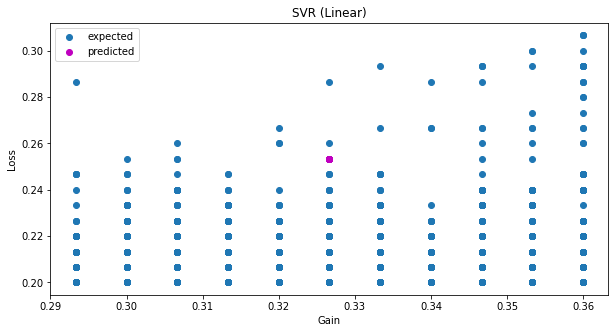

In [9]:
linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)
strategyArray.append("SVR (Linear)")
plotDistribution(linearSVR)

[38.51278005 23.67072147 24.92542623 20.73465936 44.39854964] => 5.52 (+/- 18.56)
[22.46536909  9.61760622 14.38326269  8.4506734  17.45015966] => 3.80 (+/- 10.30)


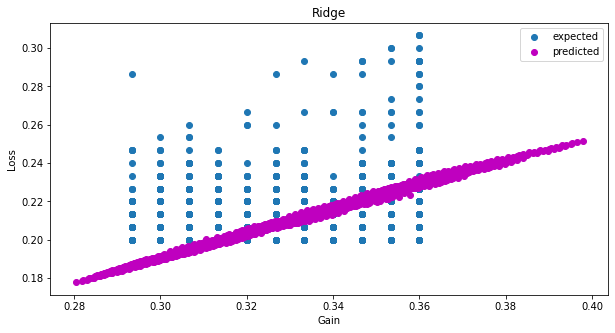

In [10]:
ridge = MultiOutputRegressor(KernelRidge(alpha = 1.0))
trainModel(ridge)
strategyArray.append("Ridge")
plotDistribution(ridge)

[13.33962006 11.86306403 10.07413732 11.73840937 10.64061871] => 3.40 (+/- 2.25)
[11.47209177  4.85630044  7.44778984  3.51630118  3.30007348] => 2.47 (+/- 6.11)


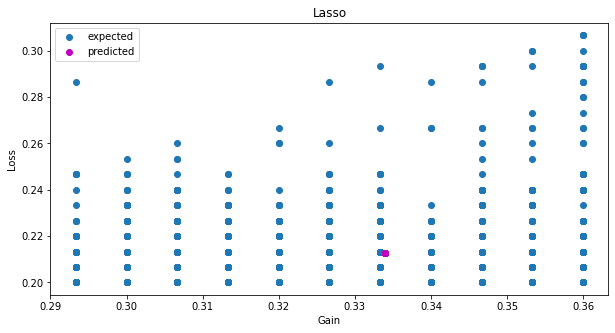

In [11]:
lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
trainModel(lasso)
strategyArray.append("Lasso")
plotDistribution(lasso)

[12.39650023 11.78969378  9.58681186 11.83562036 10.97230207] => 3.36 (+/- 1.95)
[11.12904737  4.86864475  7.37058375  3.51179939  3.09517377] => 2.45 (+/- 5.94)


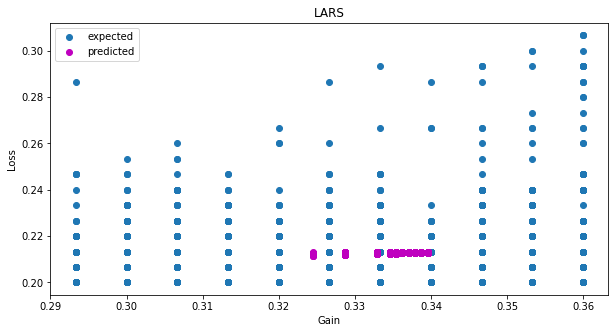

In [12]:
lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
trainModel(lars)
strategyArray.append("LARS")
plotDistribution(lars)

[11.02992775 11.84830548  9.34332043 11.51487622 18.44940845] => 3.53 (+/- 6.25)
[12.16707107  4.7225692   7.78360782  3.40898471  3.37432421] => 2.51 (+/- 6.70)


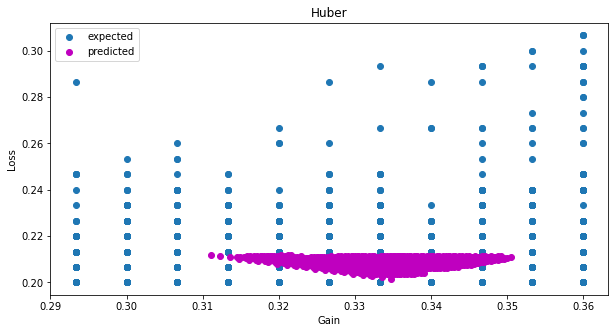

In [13]:
huber = MultiOutputRegressor(linear_model.HuberRegressor())
trainModel(huber)
strategyArray.append("Huber")
plotDistribution(huber)

[ 9.54303725  9.58532951  9.97226361 10.95358166 12.6208596 ] => 3.25 (+/- 2.32)
[11.79610315  6.24229226  6.9277937   3.39988539  3.35346705] => 2.52 (+/- 6.18)


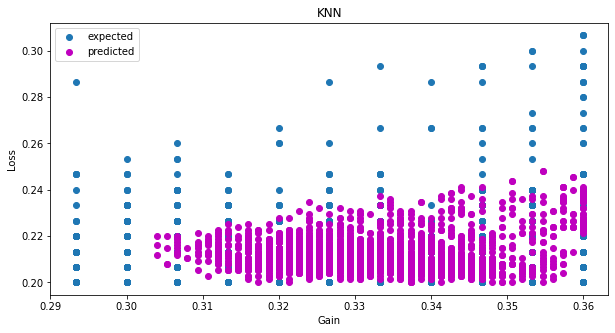

In [14]:
knn = MultiOutputRegressor(KNeighborsRegressor())
trainModel(knn)
strategyArray.append("KNN")
plotDistribution(knn)

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
trainModel(bret)
strategyArray.append("Extra Tree")
plotDistribution(bret)

# Plotting error boxplots

In [ ]:
plotGainError()
plotLossError()